In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 100

ng =7

ng_refs = (/ 5 , 2 /) 

nref =2

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 /) 

t_refs = (/ 250 , 250 /) 

tsfc =257

vstar = 620

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66/

data wgt
     &     /0 , 0.6 , 0.5 , 0.7,
     &     0.8 , 0.8 , 0.7/

atmosphere_profiles/saw75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

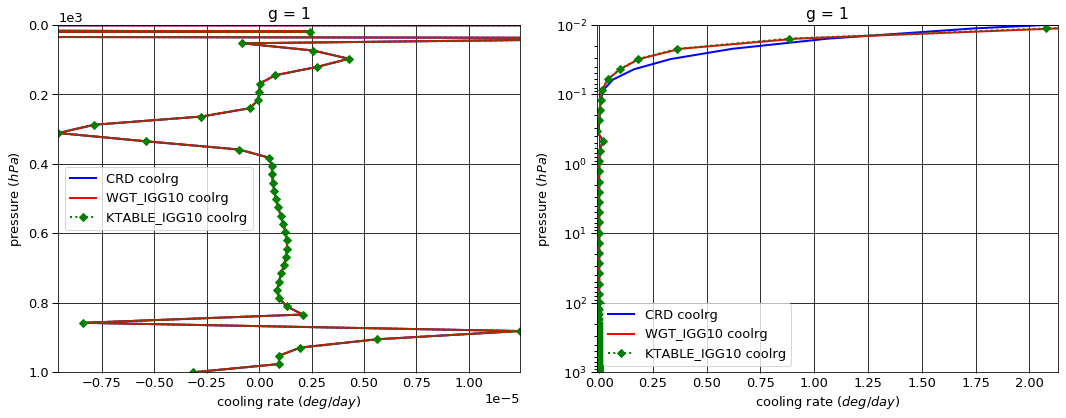

# Figure: cooling rate g-group 2

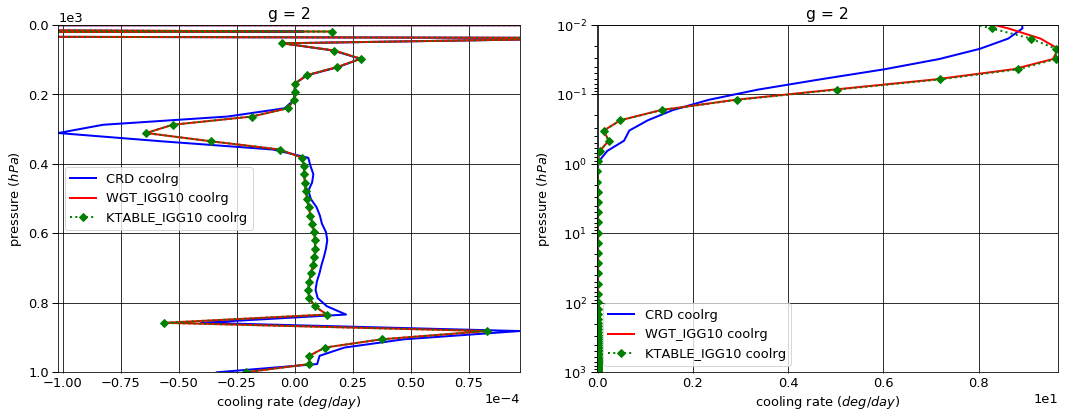

# Figure: cooling rate g-group 3

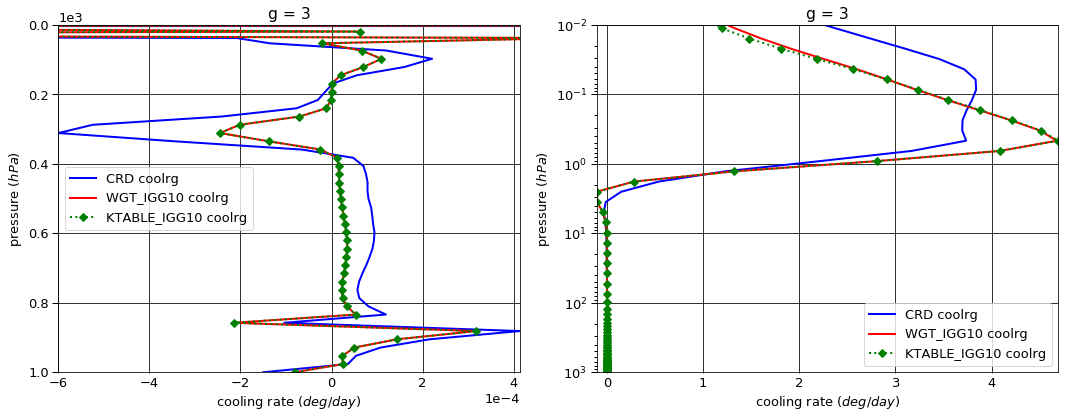

# Figure: cooling rate g-group 4

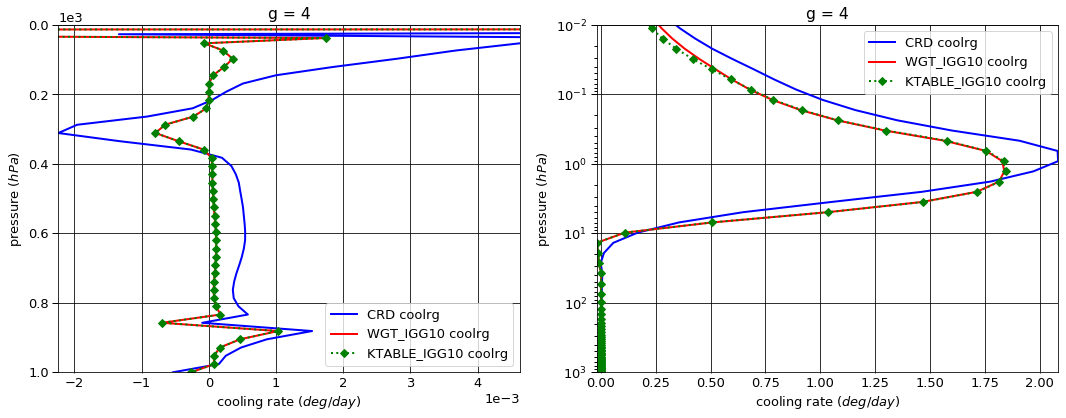

# Figure: cooling rate g-group 5

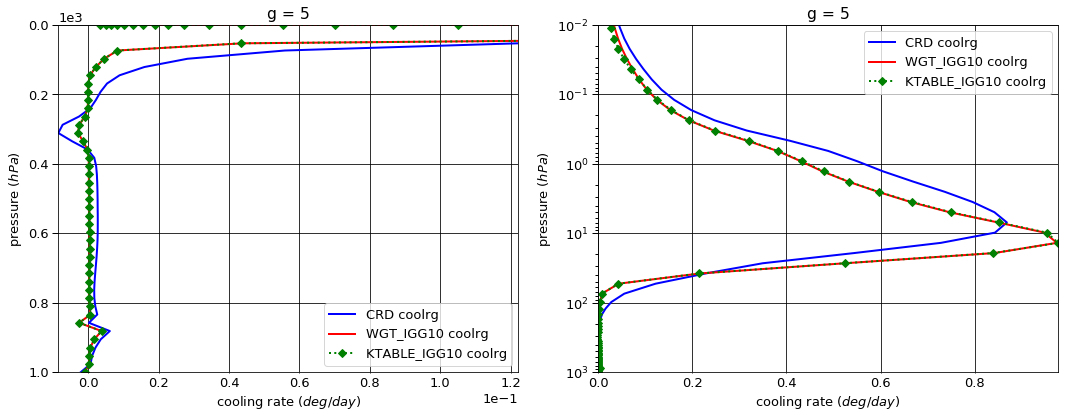

# Figure: cooling rate g-group 6

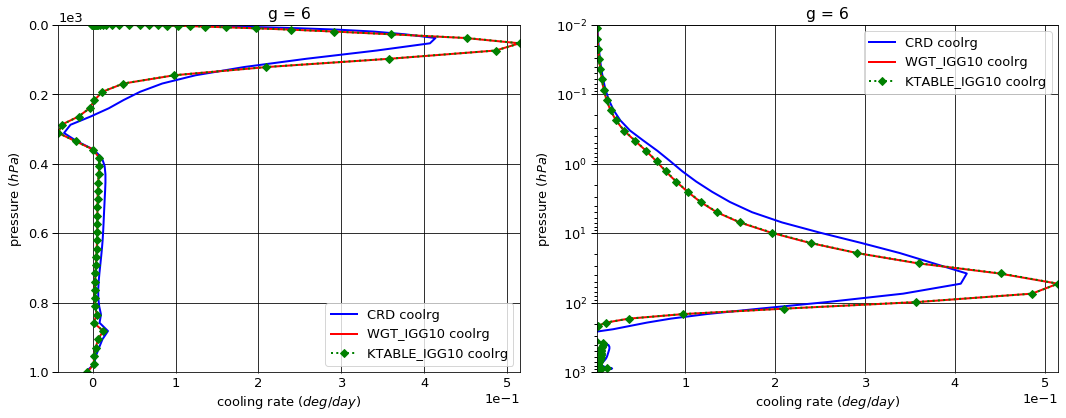

# Figure: cooling rate g-group 7

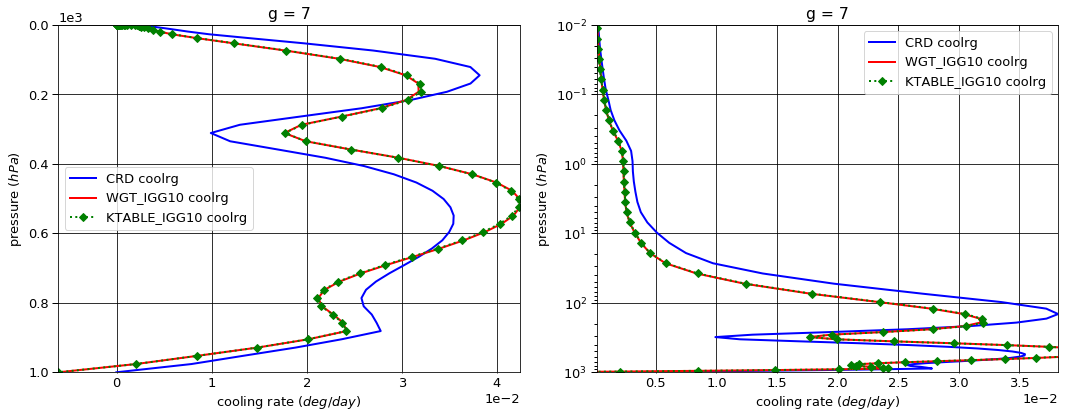

# Figure: cooling rate g-group total

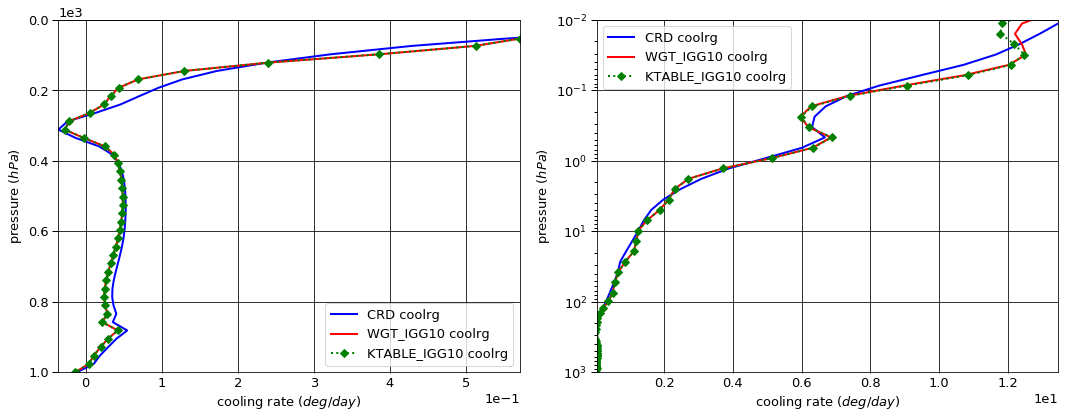

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.011612   0.000000 -0.011612
  1013.0   76     -0.021720   0.021731  0.000011
2 0.0      1      -0.119552   0.000000 -0.119552
  1013.0   76     -0.145122   0.145241  0.000119
3 0.0      1      -0.489582   0.000000 -0.489582
  1013.0   76     -0.556353   0.556945  0.000591
4 0.0      1      -1.130824   0.000000 -1.130824
  1013.0   76     -1.801406   1.803510  0.002104
5 0.0      1      -3.266321   0.000000 -3.266321
  1013.0   76     -6.636364   6.644671  0.008308
6 0.0      1      -6.173059   0.000000 -6.173059
  1013.0   76    -12.730956  12.765802  0.034847
7 0.0      1      -3.132397   0.000000 -3.132397
  1013.0   76     -5.145298   5.092638 -0.052660


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.011897   0.000000 -0.011897
  1013.0   76     -0.021720   0.021731  0.000011
2 0.0      1      -0.116776   0.000000 -0.116776
  1013.0   76     -0.145122   0.145195  0.000072
3 0.0      1      -0.512219   0.000000 -0.512219
  1013.0   76     -0.556353   0.556631  0.000277
4 0.0      1      -1.146058   0.000000 -1.146058
  1013.0   76     -1.801406   1.802303  0.000897
5 0.0      1      -3.200801   0.000000 -3.200801
  1013.0   76     -6.636364   6.639670  0.003307
6 0.0      1      -6.083243   0.000000 -6.083243
  1013.0   76    -12.730956  12.752212  0.021257
7 0.0      1      -3.000271   0.000000 -3.000271
  1013.0   76     -5.145298   5.210764  0.065466


KTABLE_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.011874   0.000000 -0.011874
  1013.0   76     -0.021720   0.021731  0.000011
2 0.0      1      -0.117186   0.000000 -0.117186
  1013.0   76     -0.145122   0.145195  0.000072
3 0.0      1      -0.512513   0.000000 -0.512513
  1013.0   76     -0.556353   0.556631  0.000277
4 0.0      1      -1.146585   0.000000 -1.146585
  1013.0   76     -1.801406   1.802303  0.000897
5 0.0      1      -3.201428   0.000000 -3.201428
  1013.0   76     -6.636364   6.639670  0.003307
6 0.0      1      -6.082749   0.000000 -6.082749
  1013.0   76    -12.730956  12.752202  0.021246
7 0.0      1      -2.997199   0.000000 -2.997199
  1013.0   76     -5.145298   5.210870  0.065572


WGT_IGG10 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -2.850740e-04  0.000000e+00 -2.850740e-04
  1013.0   76     0.000000e+00 -3.469447e-18 -1.694066e-21
2 0.0      1      2.775510e-03  0.000000e+00  2.775510e-03
  1013.0   76     0.000000e+00 -4.646000e-05 -4.645867e-05
3 0.0      1     -2.263669e-02  0.000000e+00 -2.263669e-02
  1013.0   76     0.000000e+00 -3.140500e-04 -3.140454e-04
4 0.0      1     -1.523370e-02  0.000000e+00 -1.523370e-02
  1013.0   76     0.000000e+00 -1.207500e-03 -1.207517e-03
5 0.0      1      6.552010e-02  0.000000e+00  6.552010e-02
  1013.0   76     0.000000e+00 -5.000900e-03 -5.000896e-03
6 0.0      1      8.981590e-02  0.000000e+00  8.981590e-02
  1013.0   76    -1.776357e-15 -1.359000e-02 -1.359019e-02
7 0.0      1      1.321251e-01  0.000000e+00  1.321251e-01
  1013.0   76     0.000000e+00  1.181258e-01  1.181258e-01


KTABLE_IGG10 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -2.621320e-04  0.000000e+00 -2.621320e-04
  1013.0   76     0.000000e+00 -3.469447e-18 -1.694066e-21
2 0.0      1      2.366010e-03  0.000000e+00  2.366010e-03
  1013.0   76     0.000000e+00 -4.646000e-05 -4.645867e-05
3 0.0      1     -2.293094e-02  0.000000e+00 -2.293094e-02
  1013.0   76     0.000000e+00 -3.140500e-04 -3.140454e-04
4 0.0      1     -1.576060e-02  0.000000e+00 -1.576060e-02
  1013.0   76     0.000000e+00 -1.207500e-03 -1.207517e-03
5 0.0      1      6.489290e-02  0.000000e+00  6.489290e-02
  1013.0   76     0.000000e+00 -5.000900e-03 -5.000896e-03
6 0.0      1      9.031010e-02  0.000000e+00  9.031010e-02
  1013.0   76    -1.776357e-15 -1.360000e-02 -1.360046e-02
7 0.0      1      1.351975e-01  0.000000e+00  1.351975e-01
  1013.0   76     0.000000e+00  1.182320e-01  1.182320e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer           
1 0.000312    1      32.871653
  1001.112500 75     -0.000003
2 0.000312    1       3.436472
  1001.112500 75     -0.000034
3 0.000312    1       0.054605
  1001.112500 75     -0.000151
4 0.000312    1       0.050400
  1001.112500 75     -0.000535
5 0.000312    1       0.010187
  1001.112500 75     -0.002161
6 0.000312    1       0.000331
  1001.112500 75     -0.008565
7 0.000312    1       0.000033
  1001.112500 75     -0.000035


WGT_IGG10


coolrg
g pressure    layer           
1 0.000312    1      14.105375
  1001.112500 75     -0.000003
2 0.000312    1       1.001742
  1001.112500 75     -0.000021
3 0.000312    1      -0.092328
  1001.112500 75     -0.000081
4 0.000312    1       0.055988
  1001.112500 75     -0.000261
5 0.000312    1       0.008433
  1001.112500 75     -0.000963
6 0.000312    1       0.000283
  1001.112500 75     -0.006275
7 0.000312    1       0.000025
  1001.112500 75     -0.006140


KTABLE_IGG10


coolrg
g pressure    layer           
1 0.000312    1      14.271219
  1001.112500 75     -0.000003
2 0.000312    1       0.879387
  1001.112500 75     -0.000021
3 0.000312    1      -0.075844
  1001.112500 75     -0.000081
4 0.000312    1       0.037755
  1001.112500 75     -0.000261
5 0.000312    1       0.003250
  1001.112500 75     -0.000963
6 0.000312    1      -0.000326
  1001.112500 75     -0.006268
7 0.000312    1       0.000004
  1001.112500 75     -0.006138


WGT_IGG10 - CRD


coolrg
g pressure    layer           
1 0.000312    1     -18.766278
  1001.112500 75      0.000000
2 0.000312    1      -2.434730
  1001.112500 75      0.000012
3 0.000312    1      -0.146933
  1001.112500 75      0.000070
4 0.000312    1       0.005588
  1001.112500 75      0.000274
5 0.000312    1      -0.001755
  1001.112500 75      0.001197
6 0.000312    1      -0.000048
  1001.112500 75      0.002290
7 0.000312    1      -0.000009
  1001.112500 75     -0.006105


KTABLE_IGG10 - CRD


coolrg
g pressure    layer           
1 0.000312    1     -18.600434
  1001.112500 75      0.000000
2 0.000312    1      -2.557085
  1001.112500 75      0.000012
3 0.000312    1      -0.130449
  1001.112500 75      0.000070
4 0.000312    1      -0.012646
  1001.112500 75      0.000274
5 0.000312    1      -0.006937
  1001.112500 75      0.001197
6 0.000312    1      -0.000656
  1001.112500 75      0.002297
7 0.000312    1      -0.000029
  1001.112500 75     -0.006103

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-14.323346,0.000000,-14.323346
1013.0,76,-27.037219,27.030538,-0.006680



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-14.071265,0.000000,-14.071265
1013.0,76,-27.037219,27.128505,0.091286



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-14.069533,0.000000,-14.069533
1013.0,76,-27.037219,27.128601,0.091382



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.252081,0.000000,0.252081
1013.0,76,0.000000,0.097967,0.097967



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.253813,0.000000,0.253813
1013.0,76,0.000000,0.098063,0.098063


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,36.423682
1001.112500,75,-0.011483



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,15.079518
1001.112500,75,-0.013745



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,15.115445
1001.112500,75,-0.013735



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-21.344164
1001.112500,75,-0.002262



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-21.308236
1001.112500,75,-0.002253


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.00080,0.000804
2,0.00535,0.005369
3,0.02050,0.020583
4,0.06635,0.066649
5,0.24470,0.245503
6,0.47055,0.470883
7,0.19175,0.190211


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.230874e-17
2,6.648507e-19
3,3.591161e-20
4,1.939749e-21
5,1.047746e-22
6,5.656349e-23
7,3.056898e-24


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.230874e-17,NaN,0.00080,0.000804,0.00080,0.000804,1.0
2,6.648507e-19,0.054015,0.00535,0.005369,0.00615,0.006172,1.0
3,3.591161e-20,0.054015,0.02050,0.020583,0.02665,0.026755,1.0
4,1.939749e-21,0.054015,0.06635,0.066649,0.09300,0.093403,1.0
5,1.047746e-22,0.054015,0.24470,0.245503,0.33770,0.338906,1.0
6,5.656349e-23,0.539859,0.47055,0.470883,0.80825,0.809789,10.0
7,3.056898e-24,0.054044,0.19175,0.190211,1.00000,1.000000,10.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog       ratio        taulyr
layer g pressure                                                         
1     1 0.000312     5.473965e-17  1.915374e-17    2.857910  1.013899e-01
      2 0.000312     1.019881e-18  5.415227e-19    1.883357  4.385846e-03
      3 0.000312     5.005159e-20  1.526003e-20    3.279914  1.728628e-04
      4 0.000312     1.348755e-21  4.511287e-22    2.989733  5.714135e-06
      5 0.000312     3.113479e-23  1.064080e-23    2.925982  1.431145e-07
      6 0.000312     4.787070e-25  4.276452e-25    1.119402  2.479966e-09
      7 0.000312     1.650569e-25  7.758449e-26    2.127448  7.348153e-10
2     1 0.000750     5.474844e-17  1.926630e-17    2.841669  4.107849e-02
      2 0.000750     1.039316e-18  5.498468e-19    1.890191  1.798522e-03
      3 0.000750     5.087465e-20  1.553425e-20    3.274999  7.079663e-05
      4 0.000750     1.384413e-21  4.628396e-22    2.991129  2.362288e-06
      5 0.000750     3.218209e-23  1.106858e-23    2.907519  5.961340e-08
      6 0.000750     5.127779e-25  4.586413e-25    1.118037  1.070230e-09
      7 0.000750     1.749526e-25  8.090438e-26    2.162461  3.128666e-10
3     1 0.001052     5.475930e-17  1.948824e-17    2.809865  5.827151e-02
      2 0.001052     1.079163e-18  5.663231e-19    1.905561  2.613417e-03
      3 0.001052     5.256899e-20  1.602256e-20    3.280936  1.025473e-04
      4 0.001052     1.456836e-21  4.828199e-22    3.017349  3.482348e-06
      5 0.001052     3.422644e-23  1.173454e-23    2.916728  8.888947e-08
      6 0.001052     5.686688e-25  5.074824e-25    1.120568  1.663778e-09
      7 0.001052     1.958069e-25  8.706241e-26    2.249040  4.879328e-10
4     1 0.001476     5.476146e-17  1.971239e-17    2.778023  8.268889e-02
      2 0.001476     1.120938e-18  5.832955e-19    1.921733  3.799962e-03
      3 0.001476     5.440979e-20  1.653905e-20    3.289778  1.488069e-04
      4 0.001476     1.536321e-21  5.042001e-22    3.047045  5.145657e-06
      5 0.001476     3.653200e-23  1.247375e-23    2.928711  1.330595e-07
      6 0.001476     6.346166e-25  5.649814e-25    1.123252  2.603649e-09
      7 0.001476     2.196396e-25  9.388941e-26    2.339344  7.630893e-10
5     1 0.002070     5.475466e-17  1.993608e-17    2.746510  1.172945e-01
      2 0.002070     1.164183e-18  6.005822e-19    1.938424  5.523118e-03
      3 0.002070     5.638674e-20  1.708318e-20    3.300717  2.161311e-04
      4 0.002070     1.622757e-21  5.270835e-22    3.078747  7.613607e-06
      5 0.002070     3.911448e-23  1.329728e-23    2.941540  1.997519e-07
      6 0.002070     7.124046e-25  6.327195e-25    1.125941  4.097686e-09
      7 0.002070     2.466242e-25  1.014533e-25    2.430914  1.194785e-09
6     1 0.002904     5.473882e-17  2.015955e-17    2.715280  1.663777e-01
      2 0.002904     1.208940e-18  6.182211e-19    1.955513  8.027343e-03
      3 0.002904     5.851154e-20  1.766233e-20    3.312788  3.143332e-04
      4 0.002904     1.717048e-21  5.519407e-22    3.110929  1.128617e-05
      5 0.002904     4.202283e-23  1.423115e-23    2.952877  3.009431e-07
      6 0.002904     8.051499e-25  7.134600e-25    1.128515  6.493595e-09
      7 0.002904     2.772655e-25  1.099446e-25    2.521866  1.874013e-09
7     1 0.004074     5.470634e-17  2.038149e-17    2.684119  2.359596e-01
      2 0.004074     1.255092e-18  6.362255e-19    1.972716  1.166451e-02
      3 0.004074     6.078987e-20  1.828611e-20    3.324374  4.577374e-04
      4 0.004074     1.820056e-21  5.794079e-22    3.141234  1.676211e-05
      5 0.004074     4.531322e-23  1.531181e-23    2.959365  4.551319e-07
      6 0.004074     9.169231e-25  8.108555e-25    1.130809  1.036977e-08
      7 0.004074     3.121437e-25  1.196211e-25    2.609437  2.945076e-09
8     1 0.005714     5.464874e-17  2.060055e-17    2.652781  3.345332e-01
      2 0.005714     1.302505e-18  6.546352e-19    1.989665  1.694312e-02
      3 0.005714     6.322857e-20  1.896835e-20    3.333372  6.673997e-04
      4 0.005714     1.932845e

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
